In [1]:
import xarray as xr
from cartopy import config
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import datetime
import glob 

In [2]:
# # Get a list of all .nc files available in different folders

dir_path = '/Users/jacobqs/Library/CloudStorage/OneDrive-UniversitetetiOslo/MST-HMA/Data/WFDE5'

tair_fn = glob.glob(dir_path + '/near_surface_air_temperature/*.nc')
qair_fn = glob.glob(dir_path + '/near_surface_specific_humidity/*.nc')
wind_fn = glob.glob(dir_path + '/near_surface_wind_speed/*.nc')
rainf_fn = glob.glob(dir_path + '/rainfall_flux/*.nc')
snowf_fn = glob.glob(dir_path + '/snowfall_flux/*.nc')
psurf_fn = glob.glob(dir_path + '/surface_air_pressure/*.nc')
lwdown_fn = glob.glob(dir_path + '/surface_downwelling_longwave_radiation/*.nc')
swdown_fn = glob.glob(dir_path + '/surface_downwelling_shortwave_radiation/*.nc')



In [3]:
tair_ds = xr.open_mfdataset(tair_fn, parallel = True)
#qair_ds = xr.open_mfdataset(qair_fn)
#wind_ds = xr.open_mfdataset(wind_fn)
#rainf_ds = xr.open_mfdataset(rainf_fn)
#snowf_ds = xr.open_mfdataset(snowf_fn)
#psurf_ds = xr.open_mfdataset(psurf_fn)
#lwdown_ds = xr.open_mfdataset(lwdown_fn)
#swdown_ds = xr.open_mfdataset(swdown_fn)

# Hindu Kush-Himalaya

## Time and location

In [4]:
# Dimensions of Tair data set
tair_ds.dims

Frozen({'time': 262968, 'lon': 88, 'lat': 47})

In [5]:
# Data variables in Tair data set
tair_ds.data_vars

Data variables:
    Tair     (time, lat, lon) float32 dask.array<chunksize=(744, 47, 88), meta=np.ndarray>

In [6]:
# Latitude and longitude

lats = tair_ds.lat
lons = tair_ds.lon

In [7]:
# Time

time = tair_ds.time

## Near surface temperature

In [8]:
tair_ds

<xarray.Dataset>
Dimensions:  (time: 262968, lon: 88, lat: 47)
Coordinates:
  * time     (time) datetime64[ns] 1990-01-01 ... 2019-12-31T23:00:00
  * lon      (lon) float64 61.25 61.75 62.25 62.75 ... 103.2 103.8 104.2 104.8
  * lat      (lat) float64 16.25 16.75 17.25 17.75 ... 37.75 38.25 38.75 39.25
Data variables:
    Tair     (time, lat, lon) float32 dask.array<chunksize=(744, 47, 88), meta=np.ndarray>
Attributes:
    title:        WATCH Forcing Data methodology applied to ERA5 data
    institution:  Copernicus Climate Change Service
    contact:      http://copernicus-support.ecmwf.int
    comment:      Methodology implementation for ERA5 and dataset production ...
    Conventions:  CF-1.7
    summary:      ERA5 data regridded to half degree regular lat-lon; Genuine...
    reference:    Cucchi et al., 2020, Earth Syst. Sci. Data, 12(3), 2097–212...
    licence:      The dataset is distributed under the Licence to Use Coperni...

In [9]:
# Temperature attributes

tair_attrs = tair_ds.Tair.attrs
print(tair_attrs)

{'long_name': 'Near-Surface Air Temperature', 'standard_name': 'air_temperature', 'units': 'K'}


In [10]:
# Temperature values
#tair_values = tair_ds.Tair.values

### Simple plotting

#### Using Xarray plot

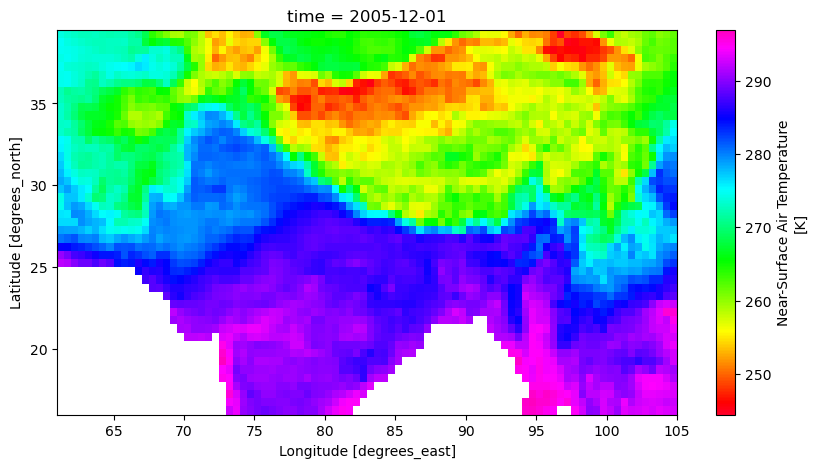

In [11]:
# Simple example plot using Xarray plot 

mytime = datetime.datetime(2005,12,1,0,0,0)
tair_ds.sel(time = mytime).Tair.plot(cmap = 'gist_rainbow', figsize = (10,5))

#### Using Basemap

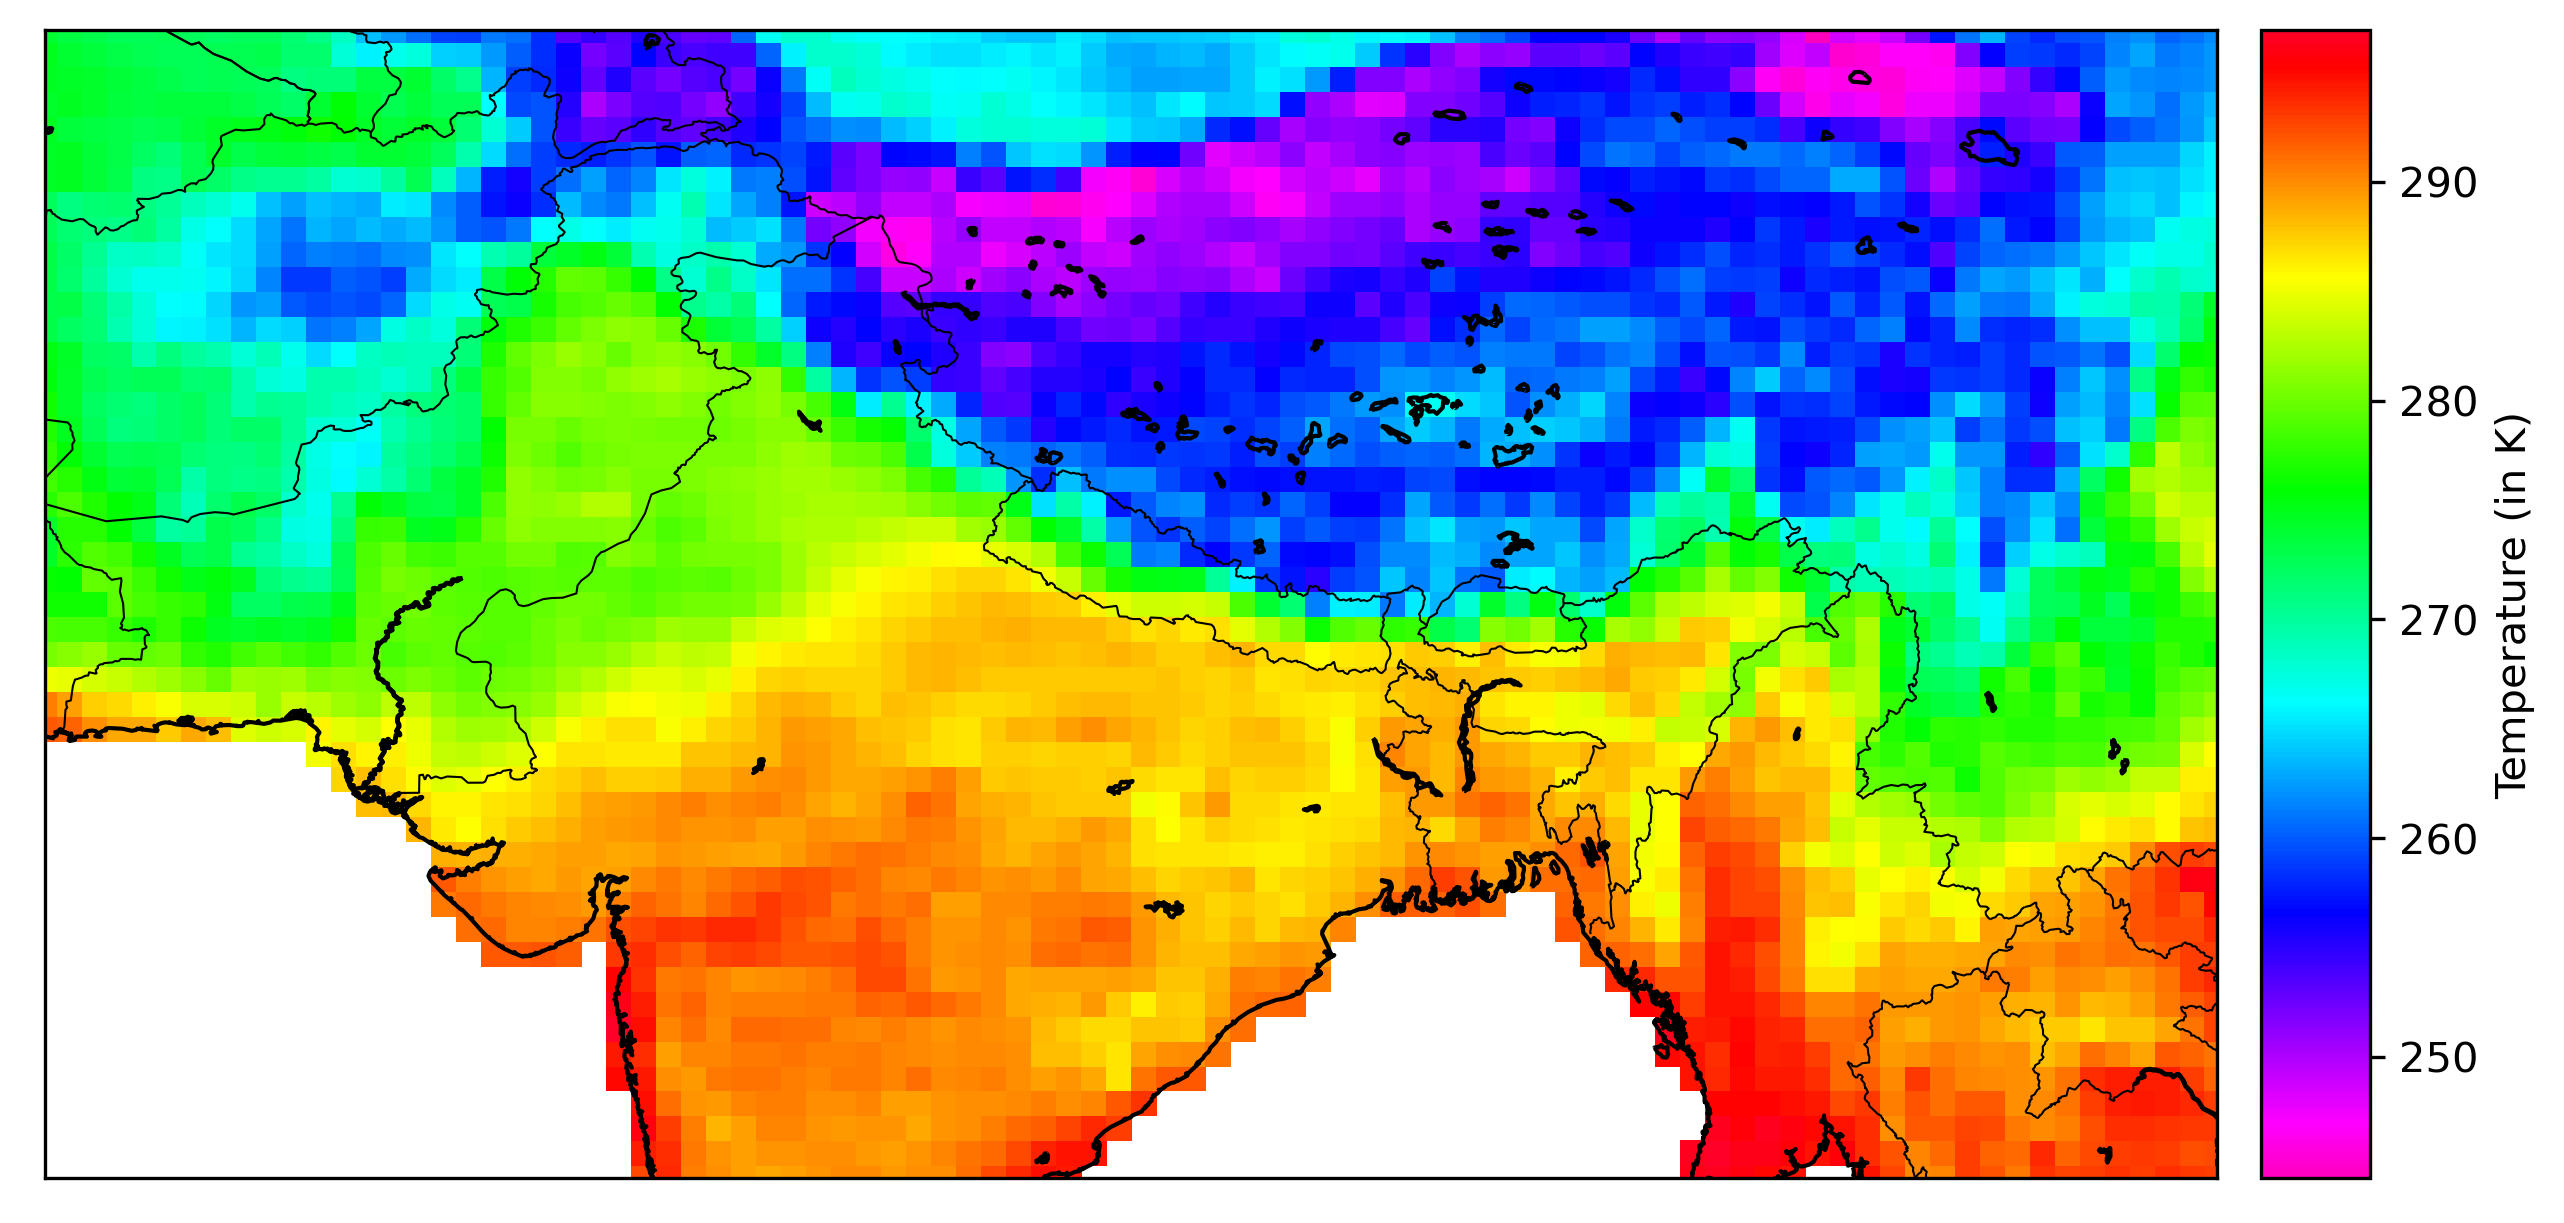

In [12]:
# Simple example plot using Basemap

# HKH coordinate bounds
min_lon = tair_ds.lon.values.min()
min_lat = tair_ds.lat.values.min()
max_lon = tair_ds.lon.values.max()
max_lat = tair_ds.lat.values.max()

# mask the coordinates
mask_lon = (tair_ds.lon >= min_lon) & (tair_ds.lon <= max_lon)
mask_lat = (tair_ds.lat >= min_lat) & (tair_ds.lat <= max_lat)

# clip the dataset for only lat lon inside HKH 
da = tair_ds.where(mask_lon & mask_lat, drop=True)

# select the time
mytime = datetime.datetime(2005, 12, 1, 0, 0, 0)
ds_sel = da.sel(time=mytime)

lat = ds_sel.lat.values
lon = ds_sel.lon.values
tair_sel_vals = ds_sel.Tair.values

mp = Basemap(projection='cyl',
llcrnrlon=min_lon,llcrnrlat=min_lat,
urcrnrlon=max_lon,urcrnrlat=max_lat,resolution='i')
lon,lat = np.meshgrid(lon,lat)
x,y = mp(lon,lat)
plt.figure(figsize=(10, 5),dpi=300)
mp.pcolor(x,y,tair_sel_vals,cmap='gist_rainbow_r')
mp.drawcoastlines()
mp.drawcountries()
mp.colorbar(label="Temperature (in K)")
plt.show()

## Daily, monthly, annually and seasonally timeseries

In [13]:
# Get daily temperature time series

tair_daily = tair_ds.resample(time = '1D').mean()

In [14]:
# Get monthly temperature time series

tair_monthly = tair_ds.resample(time = 'M').mean()

In [15]:
# Get annual temperature time series

tair_annualy = tair_ds.resample(time = 'Y').mean()

In [16]:
# Seasonal time series

tair_seasonally = tair_ds.resample(time = 'QS-DEC').mean()

## Annual mean

### Annual mean temperature 1990-2019

In [17]:
tair_mean = tair_ds.mean(dim = 'time')

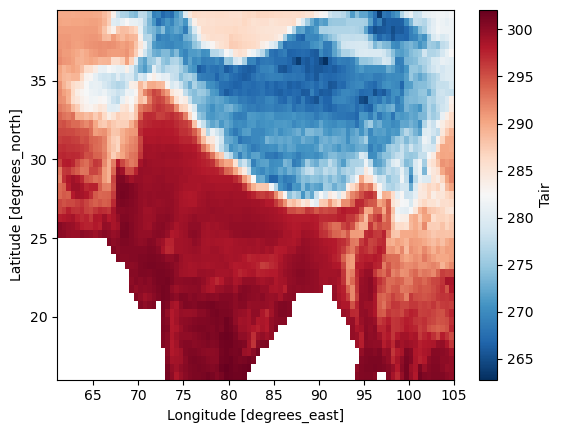

In [18]:
tair_mean.Tair.plot(cmap = plt.cm.RdBu_r)

### Seasonal mean temperature 1990-2019

To get seasonal temperature, we need to calculate the weighted average considering that each month has a different number of days.

In [19]:
dpm = {'noleap': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '365_day': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'standard': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'proleptic_gregorian': [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       'all_leap': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '366_day': [0, 31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
       '360_day': [0, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30]}

In [20]:
def leap_year(year, calendar='standard'):
    """Determine if year is a leap year"""
    leap = False
    if ((calendar in ['standard', 'gregorian',
        'proleptic_gregorian', 'julian']) and
        (year % 4 == 0)):
        leap = True
        if ((calendar == 'proleptic_gregorian') and
            (year % 100 == 0) and
            (year % 400 != 0)):
            leap = False
        elif ((calendar in ['standard', 'gregorian']) and
                 (year % 100 == 0) and (year % 400 != 0) and
                 (year < 1583)):
            leap = False
    return leap

def get_dpm(time, calendar='standard'):
    """
    return a array of days per month corresponding to the months provided in `months`
    """
    month_length = np.zeros(len(time), dtype=int)

    cal_days = dpm[calendar]

    for i, (month, year) in enumerate(zip(time.month, time.year)):
        month_length[i] = cal_days[month]
        if leap_year(year, calendar=calendar) and month == 2:
            month_length[i] += 1
    return month_length

In [21]:
# Wrap it into a simple function
def season_mean(ds, calendar='standard'):
    # Make a DataArray of season/year groups
    year_season = xr.DataArray(ds.time.to_index().to_period(freq='Q-NOV').to_timestamp(how='E'),
                               coords=[ds.time], name='year_season')

    # Make a DataArray with the number of days in each month, size = len(time)
    month_length = xr.DataArray(get_dpm(ds.time.to_index(), calendar=calendar),
                                coords=[ds.time], name='month_length')
    # Calculate the weights by grouping by 'time.season'
    weights = month_length.groupby('time.season') / month_length.groupby('time.season').sum()

    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(weights.groupby('time.season').sum().values, np.ones(4))

    # Calculate the weighted average
    return (ds * weights).groupby('time.season').sum(dim='time')

In [23]:
# Getting annual mean for the period and excluding zero values (for plot)
tair_seasonal_mean = season_mean(tair_ds)
tair_seasonal_mean = tair_seasonal_mean.where(tair_seasonal_mean.Tair > 0)

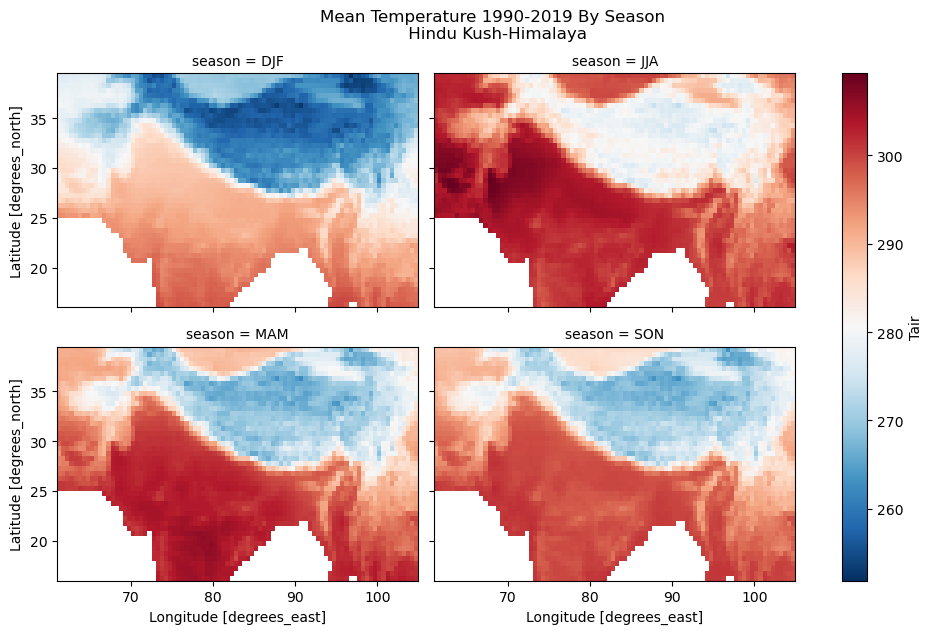

In [24]:
# Create a plot showing mean temperature aross seasons
tair_seasonal_mean.Tair.plot(col='season', col_wrap=2, figsize=(10, 6), cmap = plt.cm.RdBu_r)
plt.suptitle("Mean Temperature 1990-2019 By Season \n Hindu Kush-Himalaya",
             y=1.05)

plt.show()

In [30]:
tair_monthly_mean = tair_monthly.groupby('time.month').mean()

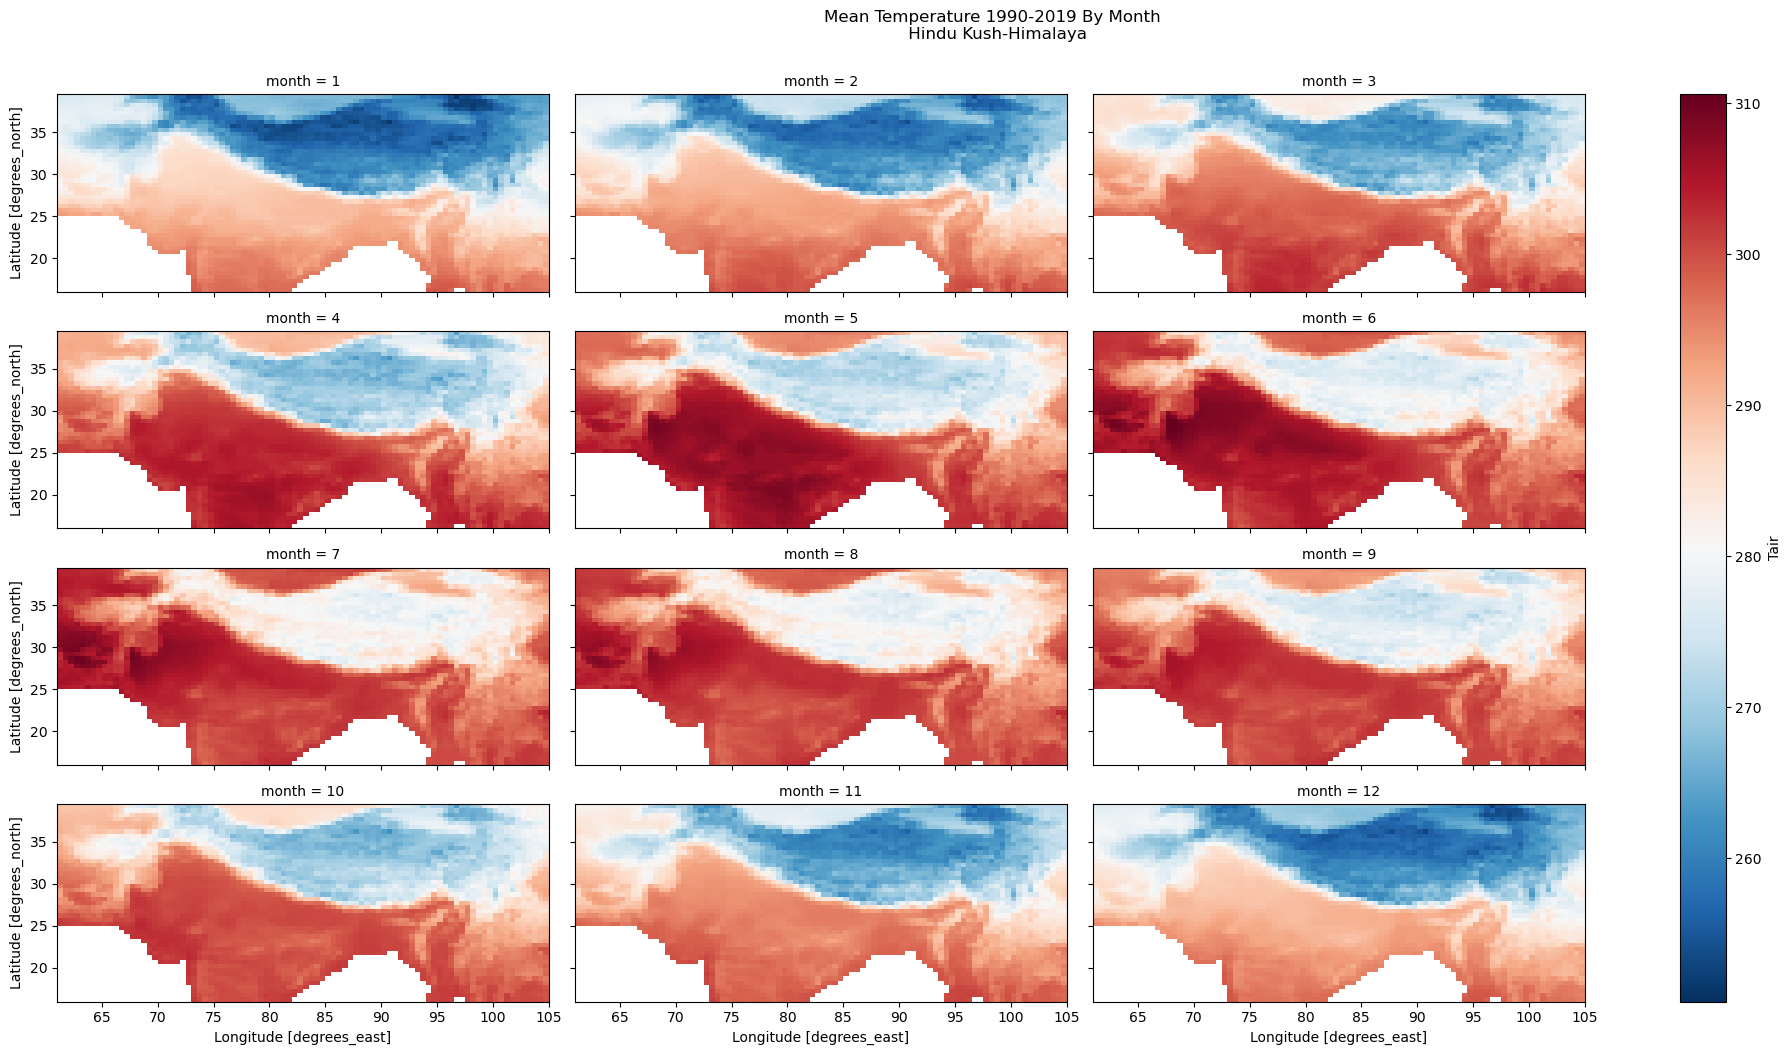

In [32]:
# Create a plot showing mean temperature aross seasons
tair_monthly_mean.Tair.plot(col='month', col_wrap=3, figsize=(20, 10), cmap = plt.cm.RdBu_r)
plt.suptitle("Mean Temperature 1990-2019 By Month \n Hindu Kush-Himalaya",
             y=1.05)

plt.show()